In [2]:
import numpy as np
import matplotlib.pyplot as plt
import operator
from functools import partial
from collections import deque
from copy import deepcopy

In [3]:
import timeit
import tracemalloc

In [4]:
DEBUG = True

In [5]:
def deviation(x, y):
    return lambda b: sum((y[i] - b[:, 0].dot(x[i])) ** 2 for i in range(len(y)))


def gradient_descent_2(lr, get_next_point, deviation, batch_size, points_number, max_iter_num=300, eps=1e-4):
    result = np.array([[0], [0]])
    log = []
    diff = deviation(result)
    for i in range(max_iter_num):
        for batch_id in range(1, points_number, points_number // batch_size):
            id = np.random.randint(batch_id, batch_id + points_number // batch_size)
            result = get_next_point(result, id, lr)
        prev_diff, diff = diff, deviation(result)
        log.append([result[0, 0], result[1, 0]])
        if abs(diff - prev_diff) < eps:
            break
    print(i + 1)
    return result, np.array(log)

In [6]:
def gen_to_next(gen):
    def next_getter(*args):
        next(gen)
        return gen.send(args)

    return next_getter

### RMS Prop

In [7]:
def rms_prop_next_point(x, y, beta):
    seq = 0

    while True:
        (result, id, lr) = yield
        xi = x[id: id + 1]
        yi = y[id: id + 1]
        grad = xi.T.dot((xi.dot(result)) - yi)
        seq = beta * seq + (1 - beta) * grad ** 2
        yield result - np.divide(lr, np.sqrt(seq)) * grad


def call_rms_prop(batch_size):
    return gradient_descent_2(0.1, gen_to_next(rms_prop_next_point(x, y, 0.8)), deviation(x, y), batch_size, len(y))

### Adam

In [8]:
def adam_next_point(x, y, beta, gamma):
    seq1 = 0
    seq2 = 0

    while True:
        (result, id, lr) = yield
        xi = x[id: id + 1]
        yi = y[id: id + 1]
        grad = xi.T.dot((xi.dot(result)) - yi)
        seq1 = beta * seq1 + (1 - beta) * grad
        seq2 = gamma * seq2 + (1 - gamma) * grad ** 2
        yield result - lr * np.divide(seq1, np.sqrt(seq2))


def call_adam(batch_size):
    return gradient_descent_2(1e-2, gen_to_next(adam_next_point(x, y, 0.8, 0.8)), deviation(x, y), batch_size, len(y))

In [9]:
def calc_pseudoinverse(x):
    return np.linalg.pinv(x.T.dot(x)).dot(x.T)


def calc_pseudoinverse_powell(x):
    return x.T.dot(x).dot(x.T) if np.linalg.det(x.T.dot(x)) == 0 else calc_pseudoinverse(x)


def calc_residual(f, x, y, coef):
    return f(x, coef) - y


def calculate_jacobian(f, x, y, x0, step):
    jacobian, y0 = [], calc_residual(f, x, y, x0)
    for i in range(len(x0)):
        new_x = x0.copy()
        new_x[i] += step
        jacobian.append((calc_residual(f, x, y, new_x) - y0) / step)
    return np.array(jacobian).T


def gradient_descent_3(pseudoinverse_f, f, x, y, start_point, max_iter_num, stop_difference=1e-10):
    coef, rmse_prev = start_point, np.inf
    differences = [sum(calc_residual(f, x, y, coef) ** 2)]
    for i in range(max_iter_num):
        residual, jacobian = calc_residual(f, x, y, coef), calculate_jacobian(f, x, y, coef, 1e-7)
        coef -= pseudoinverse_f(jacobian).dot(residual)
        differences.append(sum(calc_residual(f, x, y, coef) ** 2))
        rmse = np.sqrt(sum(residual ** 2))
        if np.abs(rmse_prev - rmse) < stop_difference:
            break
        rmse_prev = rmse
    print(i + 1)
    return coef, differences


call_gauss_newton = partial(gradient_descent_3, calc_pseudoinverse)
call_powell = partial(gradient_descent_3, calc_pseudoinverse_powell)

### Initial values for Gauss-Newton and Dog Leg comparison

In [10]:
def f(x, coef):
    return coef[0] + coef[1] * x + coef[2] * x ** 2 + coef[3] * x ** 3 + coef[4] * np.sin(x)


coef = [1, 0.1, 0.1, -1e-3, 10]
x = np.arange(1, 100)
y = f(x, coef)
yn = y + 6 * np.random.randn(len(x))
start_point = 1000 * np.random.random(len(coef))

### Gauss-Newton

5
[ 3.32233505e+00 -1.20895151e-01  1.06724596e-01 -1.05352695e-03
  9.91373125e+00] [1.310245875753804e+18, 187052.15933243505, 4184.057577333934, 4184.0575770955065, 4184.057577095425, 4184.057577095482]


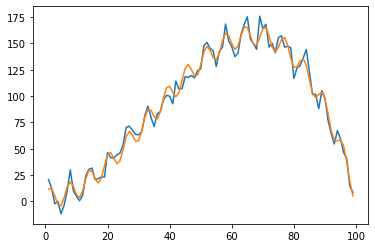

In [11]:
new_coef, differences = call_gauss_newton(f, x, yn, start_point, 500)
print(new_coef, differences)
plt.plot(x, yn)
plt.plot(x, f(x, new_coef))
plt.show()

### Dog Leg

2
[ 3.32234746e+00 -1.20896067e-01  1.06724614e-01 -1.05352705e-03
  9.91373087e+00] [4184.057577095482, 4184.057577095391, 4184.057577095678]


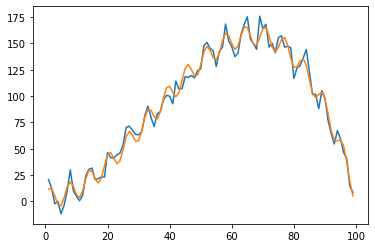

In [12]:
new_coef, differences = call_powell(f, x, yn, start_point, 500)
print(new_coef, differences)
plt.plot(x, yn)
plt.plot(x, f(x, new_coef))
plt.show()

### Initial values for 3.1

In [13]:
def g(x, coef):
    return coef[0] + coef[1] * x


x_raw = np.sort(2 * np.random.rand(100, 1), axis=0)
x = np.c_[np.ones((len(x_raw), 1)), x_raw]
y = 5 * x_raw + np.random.rand(100, 1) * 10

### 3.1 ADAM, RMS PROP, Gauss-Newton, Dog Leg

300


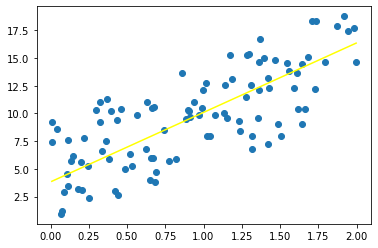

47


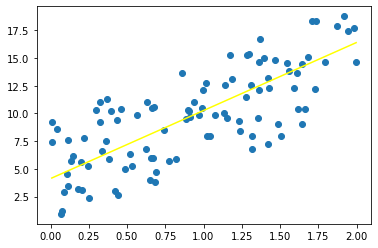

3


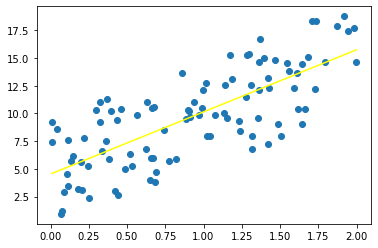

3


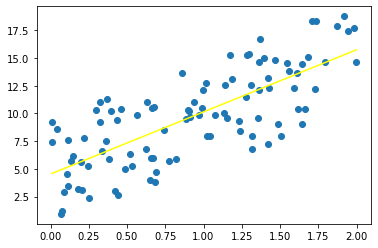

In [14]:
def draw(x_raw, x, y, coef):
    plt.scatter(x_raw, y)
    plt.plot(x_raw, x.dot(coef), c='yellow')
    plt.show()


draw(x_raw, x, y, call_adam(90)[0])

draw(x_raw, x, y, call_rms_prop(90)[0])

draw(x_raw, x, y, call_gauss_newton(g, x[:, 1], y[:, 0], np.zeros(2), 1000)[0])

draw(x_raw, x, y, call_powell(g, x[:, 1], y[:, 0], np.zeros(2), 1000)[0])

### Gradient Descent from 1.1

In [15]:
def gradient_descent(gf, x, steps, lr):
    points = np.zeros((steps, x.size))

    for i in range(steps):
        points[i] = x
        x -= lr * gf(x)

    return points

### BFGS

In [16]:
# First condition, c_1 is pretty small
def first_wolfe(alpha, phi, d_zero_phi_dir):
    c_1 = 1e-4
    return phi(alpha) <= phi(0) + c_1 * alpha * d_zero_phi_dir


# Second condition, c_2 should be as close to 1 as possible
def second_wolfe(alpha, dir, d_phi, d_zero_phi_dir):
    c_2 = 1 - 1e-4
    return d_phi(alpha).dot(dir) >= c_2 * d_zero_phi_dir


def golden_ratio_search(lr, f, df, d_zero_phi_dir, dir):
    a, b = 0, lr
    s1, s2 = 0.5 * (3 - np.sqrt(5)), 0.5 * (np.sqrt(5) - 1)
    x1, x2 = a + s1 * (b - a), a + s2 * (b - a)
    f1, f2 = f(x1), f(x2)
    while b - a >= 0.00001 and not (first_wolfe(lr, f, d_zero_phi_dir) and second_wolfe(lr, dir, df, d_zero_phi_dir)):
        if f1 < f2:
            b = x2
            x2 = x1
            f2 = f1
            x1 = a + s1 * (b - a)
            f1 = f(x1)
        else:
            a = x1
            x1 = x2
            f1 = f2
            x2 = a + s2 * (b - a)
            f2 = f(x2)
    return x1 if f1 < f2 else x2


def bfgs(f, df, x0, max_iter_num, eps=1e-5):
    I = np.eye(len(x0))
    H = I
    J = np.array(df(x0))
    x = x0
    differences = [np.linalg.norm(J)]
    points = [x]
    for i in range(max_iter_num):
        direction = -H.dot(J)
        d_zero_phi_dir = df(np.zeros(len(x))).dot(direction)
        alpha = golden_ratio_search(10, lambda a: f(x + a * direction), lambda a: df(x + a * direction), d_zero_phi_dir,
                                    direction)

        # delta x
        s = alpha * direction
        x = x + s
        points.append(x)

        # delta grad
        y = np.array(df(x)) - J
        J = y + J
        r = 1 / y.dot(s)
        A1, A2 = I - r * s[:, np.newaxis] * y[np.newaxis, :], I - r * y[:, np.newaxis] * s[np.newaxis, :]
        H = A1.dot(H).dot(A2) + r * s[:, np.newaxis] * s[np.newaxis, :]
        differences.append(np.linalg.norm(J))
        if np.linalg.norm(J) < eps or abs(differences[-1] - differences[-2]) < 1e-10:
            break
    if DEBUG: print(i + 1)
    return x, np.array(points)

### Drawing functions

In [17]:
def draw_gradient(f, points):
    plt.plot(points[:, 0], points[:, 1], color='c')
    t = np.linspace(-5, 10, 100)
    x, y = np.meshgrid(t, t)
    plt.contourf(x, y, f(np.array([x, y])), levels=sorted(set(f(p) for p in points)))


def draw_difference(f, points1, points2, axis=None):
    plt.subplot(1, 2, 1)
    if axis is not None:
        plt.axis(axis)
    draw_gradient(f, points1)

    plt.subplot(1, 2, 2)
    if axis is not None:
        plt.axis(axis)
    draw_gradient(f, points2)

    print((points1[-1], points2[-1]))

### Functions for comparison

In [18]:
def rosenbrock(a, b, x):
    return (a - x[0]) ** 2 + b * (x[1] - x[0] ** 2) ** 2


def rosenbrock_grad(a, b, x):
    return np.array([2 * (x[0] - a) + 4 * b * x[0] * (x[0] ** 2 - x[1]), 2 * b * (x[1] - x[0] ** 2)])


def gen_rosenbrock(a, b):
    return map(lambda f: partial(f, a, b), (rosenbrock, rosenbrock_grad))

### Gradient Descent and BFGS comparison

11
(array([1.94954099, 3.7982797 ]), array([1.99999996, 3.99999984]))


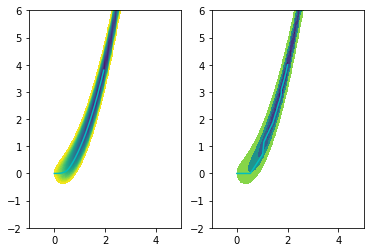

In [19]:
rosenbrock_1, rosenbrock_grad_1 = gen_rosenbrock(2, 5)
draw_difference(
    rosenbrock_1,
    gradient_descent(rosenbrock_grad_1, np.zeros(2), 2000, 0.01),
    bfgs(rosenbrock_1, rosenbrock_grad_1, np.zeros(2), 500)[1],
    axis=[-1, 5, -2, 6]
)

14
(array([1.40500217, 1.17712852]), array([1., 1.]))


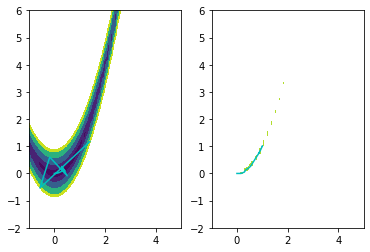

In [20]:
rosenbrock_2, rosenbrock_grad_2 = gen_rosenbrock(1, 100)
draw_difference(
    rosenbrock_2,
    gradient_descent(rosenbrock_grad_2, np.zeros(2), 35, 0.01),
    bfgs(rosenbrock_2, rosenbrock_grad_2, np.zeros(2), 500)[1],
    axis=[-1, 5, -2, 6]
)

### L-BFGS

In [21]:
def find_direction(g, r, s, y):
    q = deepcopy(g)
    m = len(r)
    alpha = [0] * m
    for i in range(m - 1, -1, -1):
        alpha[i] = r[i] * s[i].dot(q)
        q -= alpha[i] * y[i]

    gamma = s[-1].dot(y[-1]) / (y[-1].dot(y[-1]) + 1e-30)
    h_grad = gamma * q
    for i in range(m):
        beta = r[i] * np.dot(y[i], h_grad)
        h_grad += s[i] * (alpha[i] - beta)

    return -h_grad


def lbfgs(f, df, x0, max_iter_num, eps=1e-5, m=3):
    I = np.eye(len(x0))
    H = I
    J = np.array(df(x0))
    x = x0
    r, s, y = deque(), deque(), deque()
    differences = [np.linalg.norm(J)]
    points = [x]
    for i in range(max_iter_num):
        direction = -H.dot(J) if i == 0 else find_direction(J, r, s, y)
        d_zero_phi_dir = df(np.zeros(len(x))).dot(direction)
        alpha = golden_ratio_search(10, lambda a: f(x + a * direction), lambda a: df(x + a * direction), d_zero_phi_dir,
                                    direction)

        # delta x
        s0 = alpha * direction
        x = x + s0
        points.append(x)

        # delta grad
        y0 = np.array(df(x)) - J
        J = y0 + J
        r0 = 1 / y0.dot(s0)
        r.append(r0)
        s.append(s0)
        y.append(y0)
        if len(r) >= m:
            r.popleft()
            s.popleft()
            y.popleft()

        differences.append(np.linalg.norm(J))
        if np.linalg.norm(J) < eps or abs(differences[-1] - differences[-2]) < 1e-10:
            break
    if DEBUG: print(i + 1)
    return x, np.array(points)

### BFGS and L-BFGS comparison

In [22]:
def compare(f, grad, axis, *args):
    draw_difference(f, bfgs(f, grad, *args)[1], lbfgs(f, grad, *args)[1], axis)

14
14
(array([2.00000002, 4.00000005]), array([2.        , 3.99999999]))


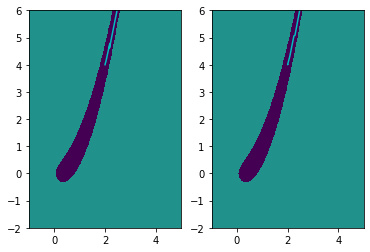

In [23]:
compare(*gen_rosenbrock(2, 5), [-1, 5, -2, 6], np.array([15., 15.]), 500)

61
27
(array([1.        , 1.00000001]), array([1., 1.]))


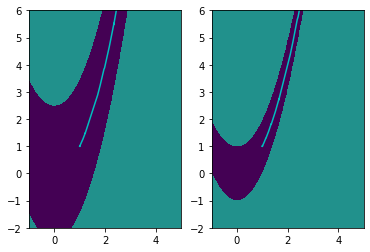

In [24]:
compare(*gen_rosenbrock(1, 100), [-1, 5, -2, 6], np.array([15., 15.]), 500)

In [25]:
def perf(f, n=20):
    print(f"Avg time: {timeit.timeit(f, number=n) / n * 1000} ms")
    sum_mem = (0, 0)
    for _ in range(n):
        tracemalloc.start()
        f()
        sum_mem = map(operator.add, sum_mem, tracemalloc.get_traced_memory())
        tracemalloc.stop()
    cur, peak = map(lambda m: f"{m / n / 1024} KB", sum_mem)
    print(f"Avg memory (cur, peak): {cur}, {peak}")

In [26]:
DEBUG = False
f, grad = gen_rosenbrock(1, 100)
print("BFGS")
perf(lambda: bfgs(f, grad, np.array([15., 15.]), 500))
print()
print("L-BFGS")
perf(lambda: lbfgs(f, grad, np.array([15., 15.]), 500))
print()

BFGS
Avg time: 44.68020500000005 ms
Avg memory (cur, peak): 14.67353515625 KB, 27.22568359375 KB

L-BFGS
Avg time: 21.797624999999954 ms
Avg memory (cur, peak): 14.7134765625 KB, 28.234228515625 KB

